In [18]:
import pandas as pd
import numpy as np
from lightgbm.sklearn import LGBMClassifier

In [19]:
df = pd.read_pickle('../../data/processed/ictcf.pkl')

In [20]:
categorical_features = ["Metadata_Sex"] + [col for col in df.columns if col.startswith("Disease_")]
numeric_features = [col for col in df.columns if col.startswith("Value_")] + ['Metadata_Age',
                                                                              'Metadata_Temperature']
input_features = categorical_features + numeric_features
output_feature = "Metadata_PCR"

In [21]:
for col in df.select_dtypes(include=['category']):
    df[col] = df[col].cat.codes.astype('category')

In [22]:
X = df[input_features]
y = df[output_feature]

In [23]:
from sklearn.base import TransformerMixin
class ColumnImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.options = {col: X[col].dropna().values for col in X.columns}
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in X.columns:
            if len(self.options[col]) > 0:
                X.loc[X[col].isna(), col] = np.random.choice(self.options[col], size=X[col].isna().sum())
        return X

In [24]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
def plot_shapley(clfs, X_unimputed):
    clf_shaps = []
    for name, n, clf, X in clfs:
        explainer = shap.TreeExplainer(clf)
        s = len(X)//n
        print(s, n, len(X))
        shaps = []
        for i in tqdm(range(n)):
            shaps.append(explainer.shap_values(X.iloc[s*i:s*(i+1), :])[1])
        print(np.array(shaps).shape)
        shaps = np.mean(shaps, axis=0)
        print(shaps.shape, X.shape)
        shap.summary_plot(shaps, features=X_unimputed)
        clf_shaps.append(pd.DataFrame({'model': name, 'missing': X_unimputed.isna().values.ravel(), 'value': shaps.ravel()}))

    clf_shaps = pd.concat(clf_shaps)
    
    plt.figure(figsize=(14, 5))
    sns.kdeplot(data=clf_shaps[clf_shaps.missing], x='value', hue='model', common_norm=False)
    plt.title('Missing shaps')
    plt.xlim(-2, 2)
    
    plt.figure(figsize=(14, 5))
    sns.kdeplot(data=clf_shaps[~clf_shaps.missing], x='value', hue='model', common_norm=False)
    plt.title('Present shaps')
    plt.xlim(-2, 2)
    
    plt.figure()
    sns.barplot(data=clf_shaps, x='model', y='value', hue='missing', estimator=lambda x: np.abs(x).mean())
#     sns.kdeplot((X.isna() * shaps).values.ravel(), label='missing')
#     sns.kdeplot(((1-X.isna()) * shaps).values.ravel(), label='present')
#     plt.legend()


In [25]:
from tqdm import tqdm
def repeated_impute(X, y, imputer, should_fit, n=100):
    X_rep = []
    y_rep = []
    
    if should_fit:
        imputer.fit(X)
        
    for i in tqdm(range(n)):
        X_rep.append(imputer.transform(X))
        y_rep.append(y)
    
    X_rep = pd.concat([pd.DataFrame(x) for x in X_rep])
    y_rep = pd.concat(y_rep)
    return X_rep, y_rep

In [33]:
from sklearn.pipeline import make_pipeline
clf2 = LGBMClassifier(n_jobs=-1)
X_rep, y_rep = repeated_impute(X, y, ColumnImputer(), should_fit=True, n=1000)
clf2.fit(X_rep, y_rep)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.06it/s]


LGBMClassifier()

In [30]:
from sklearn.pipeline import make_pipeline
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
clf3 = LGBMClassifier(n_jobs=-1)
X_rep2, y_rep2 = repeated_impute(X, y, IterativeImputer(sample_posterior=True, tol=0.005, n_nearest_features=5), should_fit=True, n=10)
clf3.fit(X_rep2, y_rep2)

 70%|████████████████████████████████████████████████████████████████████▌                             | 7/10 [08:41<03:43, 74.46s/it]


KeyboardInterrupt: 

  0%|                                                                                                           | 0/1 [00:00<?, ?it/s]

1521 1 1521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


(1, 1521, 126)
(1521, 126) (1521, 126)


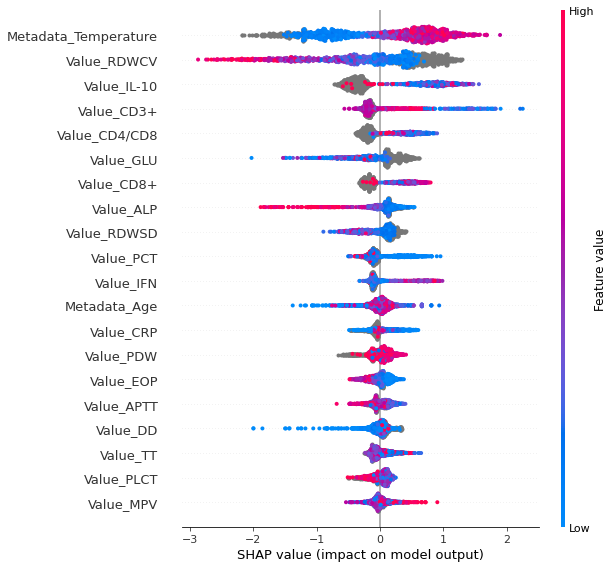

  0%|                                                                                                | 1/1000 [00:00<02:44,  6.06it/s]

1521 1000 1521000


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:54<00:00,  5.75it/s]


(1000, 1521, 126)
(1521, 126) (1521000, 126)


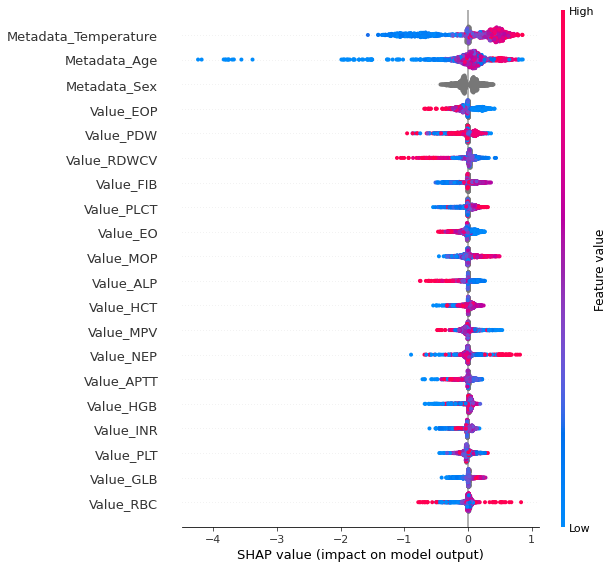

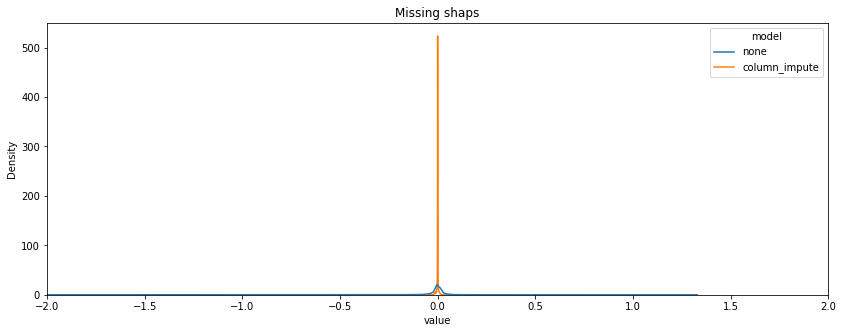

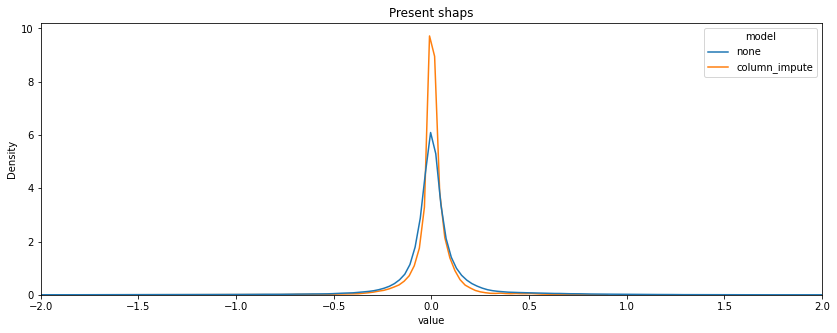

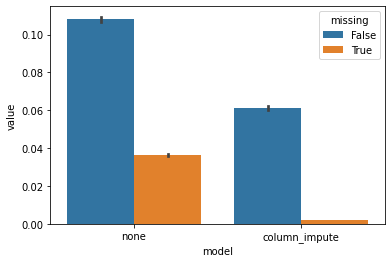

In [34]:
plot_shapley([
    ('none', 1, clf1, X), 
    ('column_impute', 1000, clf2, X_rep), 
#     ('mice_impute', 80, clf3, X_rep2)
], X)

In [146]:
from sklearn.metrics import roc_auc_score
def plot_performance(clf, imputers, X_train, y_train, X_test, y_test):
    clfs = []
    scores = []
    for name, n, imputer in imputers:
        X_rep, y_rep = repeated_impute(X_train, y_train, imputer, should_fit=True, n=n) if imputer is not None else (X_train, y_train)
        clf.fit(X_rep, y_rep)
        X_rep, y_rep = repeated_impute(X_test, y_test, imputer, should_fit=False, n=n) if imputer is not None else (X_test, y_test)
        s = len(X_test)
        preds = []
        for i in tqdm(range(n)):
#             print(s*i, s*(i+1))
#             print(X_rep.iloc[s*i:s*(i+1), :].shape)
#             print(clf.predict_proba(X_rep.iloc[s*i:s*(i+1), :]).shape)
#             print(clf.predict_proba(X_rep.iloc[s*i:s*(i+1), :])[:, 1].shape)
            preds.append(clf.predict_proba(X_rep.iloc[s*i:s*(i+1), :])[:, 1])
#         print(np.array(preds).shape)
        preds = np.mean(preds, axis=0)
        scores.append({'model': name, 'score': roc_auc_score(y_test, preds)})
        
    clf.fit(X_train, y_train)
    explainer = shap.TreeExplainer(clf)
    shaps = explainer(X_test)[:, :, 1].values
    base = explainer(X_test)[:, :, 1].base_values
    
    preds = expit(np.sum(shaps * (1-X_test.isna()), axis=1)+base)
    
    scores.append({'model': 'shap_zeroing', 'score': roc_auc_score(y_test, preds)})
    
    
    clf2 = LGBMClassifier(n_jobs=-1, **study.best_params)
    clf2.fit(X_train, y_train)
    explainer = shap.TreeExplainer(clf2)
    shaps = explainer(X_test)[:, :, 1].values
    base = explainer(X_test)[:, :, 1].base_values
    
    preds = expit(np.sum(shaps * (1-X_test.isna()), axis=1)+base)
    
    scores.append({'model': 'shap_zeroing_opt', 'score': roc_auc_score(y_test, preds)})
    
    
    sns.barplot(data=pd.DataFrame(scores), x='model', y='score')
    plt.ylim(0.5, 1.0)
    return pd.DataFrame(scores)

In [131]:
explainer = shap.TreeExplainer(LGBMClassifier().fit(X, y))

In [139]:
from bigfloat import *
def logit(p):
    with precision(100000):
        return log(p)- log(1 -BigFloat(p))

def inv_logit(p):
    with precision(100000):
        return exp(p) / (1 + exp(p))

ModuleNotFoundError: No module named 'bigfloat'

In [140]:
from scipy.special import expit

In [144]:
expit(explainer(X)[:, :, 1].base_values + np.mean(explainer(X)[:, :, 1].values * (1-X.isna()), axis=1)).min()

0.7860351875738351

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 131.59it/s]
Found `num_boost_round` in params. Will use it instead of argument


,model,score
0,none,0.906199
1,column_impute,0.750597
2,shap_zeroing,0.851598
3,shap_zeroing_opt,0.945013


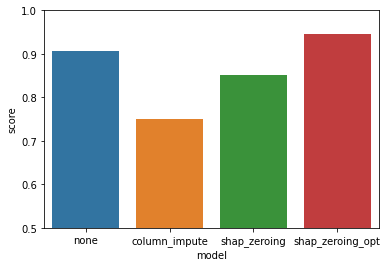

In [147]:
plot_performance(LGBMClassifier(n_jobs=-1), [
    ('none', 1, None), 
    ('column_impute', 5, ColumnImputer()), 
#     ('mice_impute', 80, IterativeImputer(sample_posterior=True))
], X.iloc[:1170], y.iloc[:1170], 
    X.iloc[1170:], y.iloc[1170:])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 136.99it/s]
Found `num_boost_round` in params. Will use it instead of argument


,model,score
0,none,0.650756
1,column_impute,0.593970
2,shap_zeroing,0.641971
3,shap_zeroing_opt,0.660313


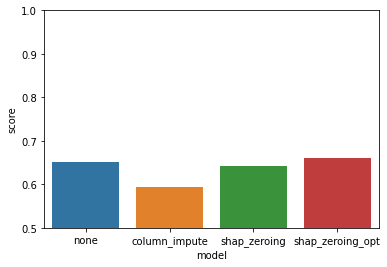

In [148]:
plot_performance(LGBMClassifier(n_jobs=-1), [
    ('none', 1, None), 
    ('column_impute', 10, ColumnImputer()), 
#     ('mice_impute', 80, IterativeImputer(sample_posterior=True))
], X[df.Metadata_Hospital == 'Union'], y[df.Metadata_Hospital == 'Union'], 
    X[df.Metadata_Hospital != 'Union'], y[df.Metadata_Hospital != 'Union'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 100.00it/s]
Found `num_boost_round` in params. Will use it instead of argument


,model,score
0,none,0.673319
1,column_impute,0.545383
2,shap_zeroing,0.651004
3,shap_zeroing_opt,0.700129


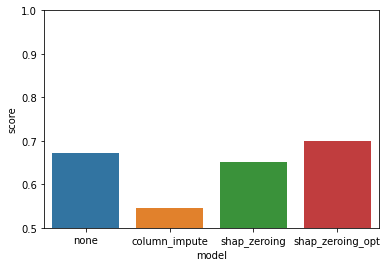

In [149]:
plot_performance(LGBMClassifier(n_jobs=-1), [
    ('none', 1, None), 
    ('column_impute', 10, ColumnImputer()), 
#     ('mice_impute', 80, IterativeImputer(sample_posterior=True))
], X[df.Metadata_Hospital != 'Union'], y[df.Metadata_Hospital != 'Union'], 
    X[df.Metadata_Hospital == 'Union'], y[df.Metadata_Hospital == 'Union'])

In [38]:
df.Metadata_Hospital

0       Union
1       Union
2       Union
3       Union
4       Union
        ...  
1516    Union
1517    Union
1518    Union
1519    Union
1520    Union
Name: Metadata_Hospital, Length: 1521, dtype: object

In [95]:
import re
class PasswordFilter(object):
    def __init__(self, strings_to_filter, stream):
        self.stream = stream
        self.strings_to_filter = strings_to_filter

    def __getattr__(self, attr_name):
        return getattr(self.stream, attr_name)

    def write(self, data):
        if data.strip() == '' and '\n' in data:
            return
        for string in self.strings_to_filter:
            if string in data:
                return
        self.stream.write(data)
        self.stream.flush()

    def flush(self):
        self.stream.flush()

In [96]:
import sys
old_out = sys.stdout

In [97]:
filter_words = ['[LightGBM]']
sys.stdout = PasswordFilter(filter_words, old_out)

In [123]:
import optuna
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
import warnings
cv = RepeatedStratifiedKFold(n_repeats=5)
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf', 'goss']),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 100.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 100.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 400),
        'max_depth': trial.suggest_int('max_depth', 0, 40), 
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1.0),
        'feature_fraction_bynode': trial.suggest_uniform('feature_fraction_bynode', 0.01, 1.0), 
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 200),
        'linear_tree': False, 
        'feature_pre_filter': False, 
        'max_bin': trial.suggest_int('max_bin', 7, 511), 
        'extra_trees': trial.suggest_categorical('extra_trees', [False, True]), 
        'path_smooth': trial.suggest_loguniform('path_smooth', 1e-12, 100), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-30, 1), 
        'min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 1e-20, 100), 
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-6, 1e2), 
        'num_boost_round': trial.suggest_int('num_boost_round', 2, 600)
    }
    
    if param['boosting_type'] != 'goss':
        not_goss_params = {
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.999999),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 100),
        }
        param.update(not_goss_params)

    if param['boosting_type'] == 'dart':
        dart_params = {
          'drop_rate': trial.suggest_uniform('drop_rate', 0.01, 1.0), 
          'max_drop': trial.suggest_int('max_drop', 0, 200), 
          'skip_drop': trial.suggest_uniform('skip_drop', 0.001, 1.0), 
          'xgboost_dart_mode': trial.suggest_categorical('xgboost_dart_mode', [False, True]), 
          'uniform_drop': trial.suggest_categorical('uniform_drop', [False, True])
        }

        param.update(dart_params)
    
    clf = LGBMClassifier(n_jobs=-1, **param)
    scores = []
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            clf.fit(X_train, y_train)

            explainer = shap.TreeExplainer(clf)
            shaps = explainer(X_test)[:, :, 1].values
            base = explainer(X_test)[:, :, 1].base_values

            preds = expit(np.sum(shaps * (1-X_test.isna()), axis=1)+base)

            scores.append(roc_auc_score(y_test, preds))
    return np.mean(scores)

In [124]:
study = optuna.create_study(direction='maximize')

[I 2021-05-27 13:34:40,627] A new study created in memory with name: no-name-2254b374-8e86-426b-b78f-3ad83061e31b


In [126]:
study.optimize(objective, n_trials=400)

[I 2021-05-27 13:48:00,613] Trial 48 finished with value: 0.8384417791104447 and parameters: {'boosting_type': 'goss', 'lambda_l1': 7.754384626594974e-07, 'lambda_l2': 14.476106790993354, 'num_leaves': 61, 'max_depth': 26, 'feature_fraction': 0.7615989978836574, 'feature_fraction_bynode': 0.45156429199096004, 'min_child_samples': 22, 'max_bin': 298, 'extra_trees': True, 'path_smooth': 2.1030131507866624e-06, 'learning_rate': 6.807330088310087e-11, 'min_gain_to_split': 1.8264637958904708e-17, 'min_sum_hessian_in_leaf': 23.350482300630443, 'num_boost_round': 433}. Best is trial 30 with value: 0.8600383935016619.
[I 2021-05-27 13:49:06,258] Trial 49 finished with value: 0.8617440644756985 and parameters: {'boosting_type': 'goss', 'lambda_l1': 0.00023852603870831092, 'lambda_l2': 0.0021012494440733245, 'num_leaves': 136, 'max_depth': 30, 'feature_fraction': 0.6348198903050094, 'feature_fraction_bynode': 0.5552045473373022, 'min_child_samples': 2, 'max_bin': 352, 'extra_trees': True, 'path_

KeyboardInterrupt: 

In [127]:
study.best_params

{'boosting_type': 'goss',
 'lambda_l1': 0.0037684479636952727,
 'lambda_l2': 1.382520442108721e-08,
 'num_leaves': 114,
 'max_depth': 8,
 'feature_fraction': 0.6746754447400268,
 'feature_fraction_bynode': 0.9172435694369678,
 'min_child_samples': 9,
 'max_bin': 322,
 'extra_trees': True,
 'path_smooth': 2.36459198341578e-11,
 'learning_rate': 2.0537008565979384e-06,
 'min_gain_to_split': 0.010926779062957174,
 'min_sum_hessian_in_leaf': 0.7264251869882694,
 'num_boost_round': 235}

In [151]:
df.Metadata_Hospital.unique()

array(['Union', 'Liyuan'], dtype=object)